# Mezclado de regiones usando la ecuación de Poisson 

Trabajo final de visión por computador curso 2021-2022

Miembros equipo: 
- Exequiel Alberto Castro Rivero 
- Blanca Cano Camarero 

## Descripción del problema   
TODO: issue #8 redacción mejor cuando esté acabado 
Clonación de regiones   

## Elementos del problema   

Relacionaremos la notación usada de manera teórica: 

El dominio total de la imagen consiste en la unión de los píxeles 
$\Omega \cup S$. 

Donde $S$ representa  la posición de píxeles de la imagen destino que **no** modificarán su valor durante el clonado. 
A su vez, $\Omega$ representa a la área de la imagen destino que va a ser alterada. 
  
Todo pixel $p$ de $S \cup \Omega$ será un par que denotará sus coordenada dentro de la imagen. 
Y su **conjunto de vecinos del pixel $p$** denotado como $N_p$ serán calculados gracias a la función `Neighborhood` que definida en la celda de `Código: 1`. 


Será necesario calcular también el **borde  de $\Omega$**, que definíamos de manera formal como: 

$$\partial\Omega = \{ p \in S \setminus \Omega : N_p \cap \Omega \neq  \emptyset \}$$

Su cálculo se realizará mediante la función `SourceBoundary`, también definida en la celda `Código: 1`.

Falta ahora por definir el valor de cada pixel dentro de la imagen. Esto viene dado por las funciones 
$f: \Omega \longrightarrow \mathbb R$ que representa la función con la que realizaremos la interpolación y $f^*: S \longrightarrow \mathbb R$ que son los valores conocidos de la imagen destino. 


El objetivo a resolver de nuestro problema consiste en calcula $f$. 

Notación: Para una función cualquiera $h$ y un elemento de su dominio $x$, denotaremos a la imagen  $h(x)$ como $h_x$. 


In [23]:
# Código: 0   Import básico y otras definiciones globales auxiliares
import numpy as np
from itertools import chain # Herramienta de programación funcional

# Para la lectura de las imágenes
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Para las matrices dispersas
from scipy.sparse import lil_matrix
import scipy.sparse.linalg

#import scipy.special
# ___ Lectura de imágenes___
# path carpeta con imágenes
path = 'images/'


# TODO: BORRAR la función TODO ANTES DE ENTREGAR
def TODO (ms): 
    '''
    Función auxiliar para indicar que una función está en desarrollo
    '''
    print('TODO', ms)



In [2]:
#Código: 1
def Neighborhood(pixel : list, inputChannel : np.ndarray )->list:
    '''
    pixel: tupla o lista de dos números naturales que indican  las coordenadas del pixel. se comprobará que que es coherente con las dimensiones de la imagen
    inputChannel: imagen a la que pertenece el pixel p. Debe ser solo un canal. Es decir, será una matriz de dos dimensiones. 
    '''
    x,y = pixel
    #Dimensiones de inputChannel coherente con el pixel demandado
    x_max , y_max = np.shape(inputChannel) 
    DimensionChecker = lambda x,y: 0 <= x < x_max and 0 <= y < y_max
    assert DimensionChecker(x,y), f' El pixel {pixel} se sale de las dimensiones {x_max}{y_max}'

    #Se devuelven vecino válidos
    neighborhoodCoordinates = filter(
        lambda tuple : DimensionChecker(tuple[0], tuple[1]),
        list( chain.from_iterable(([x+i,y], [x, y+i]) for i in [-1,1])) 
    )
   
    return list(neighborhoodCoordinates)


def SourceBoundary(inputChannel: np.ndarray, O: set )-> set : 
    '''
    Se pretenda calcular el borde de imagen destino. 

    inputChannel: imagen a la que pertenece el pixel p. Debe ser solo un canal. Es decir, será una matriz de dos dimensiones. 
    O: Supondremos que O son n conjunto de pares de tuplas de coordenadas. 

    Devuelve un conjunto de coordenadas en tuplas que son el borde de O.
    ''' 
    # calculamos el conjunto de puntos S
    x_len, y_len = np.shape(inputChannel)
    S = set( (i,j) for i in range(x_len) for j in range(y_len)) 
    # Calculamos la diferencia 
    difference = S.difference(O)
    # Filtramos los puntos que cumplen la condición de que sus vecinos están en O
    boundary = set(filter(
        lambda p : len(set(
            map(
                lambda l : tuple(l),
                Neighborhood(p, inputChannel)
            )
            ).intersection(O))>0,
        difference
    ))

    return boundary

### Complejidad de las funciones implementadas 

Para la función `Neighborhood(pixel : list, inputChannel : np.ndarray )`  de la celda `Código: 1` su eficiencia reside: 
- Coste funciones ya implementada de python y bibliotecas. 
- De nuestro propio código.   

La de nuestro propio código es $O(1)$ ya que no existe ningún bucle interno que dependenda de la entrada de la función. 
Para funciones externas la única función que podría contener un coste mayor de $O(1)$ podría ser la función `shape` de numpy. Consultando su implementación [1] se puede apreciar que usa dos funciones `len` que volviendo a analizar su eficiencia [2] esta es $O(1)$. 

Por lo que concluimos que `Neigborhood` tiene una complejidad de $O(1)$. 

TODO Complejidad de `SourceBoundary`. 

## Copiado prístino   

Para una implementación numérica, la traducción de las especificaciones continuas se trasladan directamente en : 

$\langle p,q \rangle, v_{p,q} = g_p - g_q$

Donde $g_p$ representa el valor del pixel $p$ en la imagen de entrada. 
Así pues el resultado de la implementación queda escrito en la celda `Código: 2` la siguiente. 

In [3]:
# Código: 2 Implementación del campo de guía  

def GuidanceFieldGenerator(inputChannel : np.ndarray):
    ''' Devuelve la función v_{p,q} = g_p - g_q$
    Para el caso particular en que g es inputChannel
    '''
    return lambda p,q : inputChannel[p[0]][p[1]] - inputChannel[q[0]][q[1]]

### Lectura de imágenes  

No olvidemos ahora la lectura de las imágenes. 

TODO: Aquí queda pensar cómo se va a leer para definir correctamente cada uno de los dominios. 

También será necesario buscar imágenes que sean adecuadas para nuestro problema, hemos realizado capturas del artículo original [3]. 

Para leer las imágenes utilizaremos las funciones de `opencv`, las leeremos en color. Como resultado (ver referencia a (1) en la salida de códico: 3)
obtendremos dos canales con los que trabajaremos de forma separada. 

Además podemos observar en la salida (1) que el número de píxeles de la imagen *Piel rugosa* es de $968 \times 1052$, mientras que para *Pintada de pared* es de $1092 \times 2138$.


(Nota para el futuro: estas imágenes puede ser muy grandes)


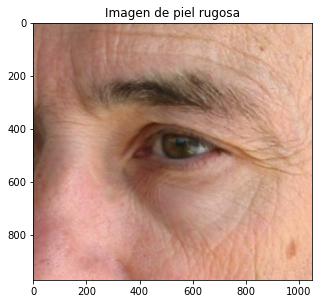

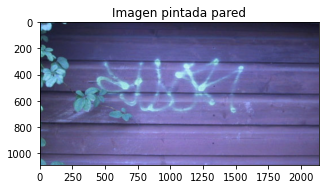

Salida (1) Sobre el tamaño de las imágenes: 
 Shape piel rugosa: (968, 1052, 3)
Shape pintada pared: (1092, 2138, 3)


In [4]:
# Código: 3 Funciones lectura de imágenes 
'''
Salvo tener la necesidad de cambiar la ruta donde se leen las imágenes, no es necesario la lectura de ésta
celda, ya que contiene: 
1. Bibliotecas necesarias.
2. Indicación de la ruta de donde se toman las imágenes y la lectura de las imágenes.
3. Conjunto de funciones auxiliaras como las utilizadas para mostrar imágenes en pantalla. 
Éstas están tomadas de la práctica 0 y a lo sumo tienen ligeras modificaciones.  
'''
# ___ Lectura de imágenes___
# path carpeta con imágenes
path = 'images/'

# Devuelve si una imagen está en blanco o negro 
def IsGreyScale(img):
    '''Devuelve si una imagen está en blanco y negro'''
    return len(img.shape) == 2

# Reutilizamos código de la práctica inicial
def ReadImage(filename, flagColor):
  '''
  @param filename: nombre de la foto 
  @para flagColor: boolean escala de grises o color
  '''
  return np.asarray(cv.imread(filename, flagColor), dtype=float)
## Flags
flagColor = cv.IMREAD_ANYCOLOR
flagGrey = cv.IMREAD_GRAYSCALE


## Algunas funciones para pintar imágenes 
# Para pintar imágenes
def Normalize (img):
    ''' Transforma una imagen de números reales
    al intervalo [0,1] 
    '''
    min = np.min(img)
    max = np.max(img)

    normalized_img = np.copy(img)

    if max - min > 0:
        normalized_img = (normalized_img - min) / (max - min)
    else: 
        normalized_img *= 0 # suponemos todo blanca
    return normalized_img

def PrintOneImage( img, title=None, normalize= True, size = (13,13)):
    '''Muestra una imagen usando imshow'''

    plt.figure(figsize=size)
    if normalize:
        img = Normalize(img)
    if IsGreyScale(img):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if title:
        plt.title(title)
    plt.show()


## Leemos algunas imágenes y las mostramos  
pathPielRugosa = path + 'PielRugosa.png'
pathPintadaPared = path + 'PintadaEnPared.png'
imgPielRugosa = ReadImage(pathPielRugosa, flagColor) 
imgPintadaPared = ReadImage(pathPintadaPared, flagColor)
PrintOneImage(imgPielRugosa, title='Imagen de piel rugosa',size=(5,5))
PrintOneImage(imgPintadaPared, title='Imagen pintada pared', size=(5,5))

# Características de las imágenes 
print('Salida (1) Sobre el tamaño de las imágenes: ')
print(f' Shape piel rugosa: {imgPielRugosa.shape}')
print(f'Shape pintada pared: {imgPintadaPared.shape}')


### Selección de regiones   

Es necesario definir un sistema de selección de regiones para nuestro problema, es decir de lo que de manera teórica sería definir las regiones $\Omega$ y $S$. Para ello hemos definido el siguiente método: 

Se subirán dos imágenes, una la original sin seleccionar el área, otra la que tiene el área seleccionada. Para indicar las regiones lo que se hará será cambiar cambiar el color de esa región. 

Mostramos ejemplo en  `Código: 5` y `Código: 6`. 

La implementación del cálculo, en sección `Código: 4` de región consiste en cambiar el color de las regiones que se quieren cambiar:
Se restan las matrices que representan las imágenes originales y la nueva, las entradas no nulas representa los píxeles seleccionados.
Este método supone un esfuerzo al que edita las imágenes: debe cambiar el color correctamente (es decir si lo hace coloreando esa región con un color, debe asegurarse de que ese color no está en ningún pixel de la zona. Para ello recomendamos usar algoritmos propios del sistema de edición con que edite la foto.)

Otro problema ahora a hacer frente es dónde posicionar esos píxeles en la otra imagen y con qué escala.
Eso se hará gracias a un homomorfismo. (TODO: issue #12 Revisar que la función utilizada es pegado regiones es homomorfismo).




In [5]:
# Código 4: Selección de regiones 

def SelectedRegion( originalImage: np.ndarray, selectedImage : np.ndarray, showImage = False) -> set :
    '''
    Devuelve un conjunto de pares de coordenadas que han sido modificadas en alguno de los tres canales. 
    Su correspondencia teórica sería $\Omega$. 
    originalImage: Imagen en la que no se ha seleccionado ningún área. 
    selectedImage: Imagen con el área seleccionada. 
    showImage: Booleano si True muestra las regiones seleccionadas. 
    '''

    assert originalImage.shape == selectedImage.shape, f'El tamaño de las imágenes no son iguales, son de tamaño: {originalImage.shape} y {selectedImage.shape}'
    differenceMatrix = originalImage - selectedImage
    if(showImage):
        PrintOneImage(differenceMatrix, title= 'Regiones seleccionadas',size=(7,7))

    #seleccionamos las coordenadas que han cambiado
    x_len, y_len, _ = differenceMatrix.shape
    selectedRegion = set()
    for x in range(x_len):
        for y in range(y_len): 
            if (
                differenceMatrix[x][y][0] != 0
                or differenceMatrix[x][y][1] != 0
                or differenceMatrix[x][y][2] != 0 
            ):
                selectedRegion.add((x,y))

    return selectedRegion



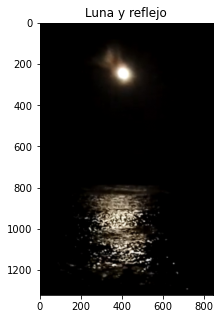

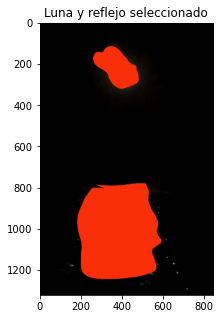

 Shape Luna y reflejo: (1322, 842, 3)
Shape luna y reflejo seleccionados: (1322, 842, 3)


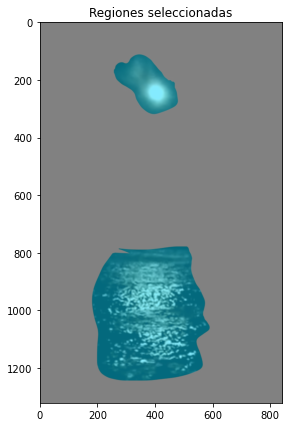

In [6]:
# Código 5: Ejemplo de selección de imágenes

#Leemos las imágenes y las mostramos 
pathLunaYReflejo = path + 'LunaYReflejo2.jpg'
pathLunaSeleccionada = path + 'LunaYReflejoSeleccionados2.jpg'
imgLunaYReflejo = ReadImage(pathLunaYReflejo, flagColor) 
imgLunaSeleccionada = ReadImage(pathLunaSeleccionada, flagColor)
PrintOneImage(imgLunaYReflejo, title='Luna y reflejo',size=(5,5))
PrintOneImage(imgLunaSeleccionada, title='Luna y reflejo seleccionado', size=(5,5))
# Imprimimos tamaño de las imágenes
print(f' Shape Luna y reflejo: {imgLunaYReflejo.shape}')
print(f'Shape luna y reflejo seleccionados: {imgLunaSeleccionada.shape}')
# Calculamos las diferencias y las mostramos en pantalla
setRegionesSeleccionadasLuna= SelectedRegion(imgLunaYReflejo, imgLunaSeleccionada, True) 

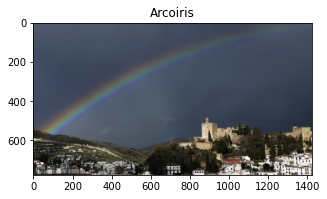

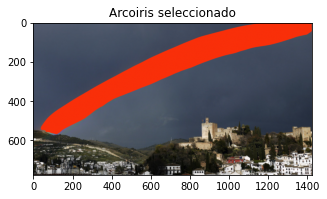

 Shape del arcoiris: (776, 1427, 3)
Shape arcoiris seleccionado: (776, 1427, 3)


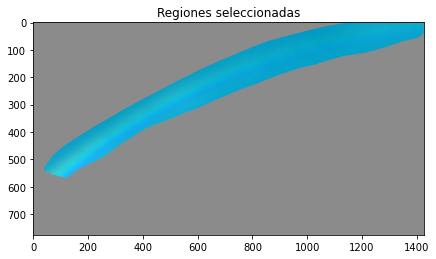

In [7]:
# Código 6: Ejemplo de selección de imágenes

#Leemos las imágenes y las mostramos 
pathArcoiris = path + 'Arcoiris.png'
pathArcoirisSeleccionado = path + 'ArcoirisSeleccionado.png'
imgArcoiris = ReadImage(pathArcoiris, flagColor) 
imgArcoirisSeleccionado = ReadImage(pathArcoirisSeleccionado, flagColor)
PrintOneImage(imgArcoiris, title='Arcoiris',size=(5,5))
PrintOneImage(imgArcoirisSeleccionado, title='Arcoiris seleccionado', size=(5,5))
# Imprimimos tamaño de las imágenes
print(f' Shape del arcoiris: {imgArcoiris.shape}')
print(f'Shape arcoiris seleccionado: {imgArcoirisSeleccionado.shape}')
# Calculamos las diferencias y las mostramos en pantalla
setRegionesSeleccionadasArcoiris= SelectedRegion(imgArcoiris, imgArcoirisSeleccionado, True) 


# Ejemplo de cálculo de borde 
Veremos ahora un ejemplo de cálculo del borde en la sección `Código: 7`. 

Será necesario: 
1. Separar la imagen en canales. 
2. Calcular en un canal el borde, que será el mismo para el resto de canales. 

Además para visualizar el borde se ha implementado en `Código: 7` la función `ViewBoundary`, que muestra en negro el borde. 

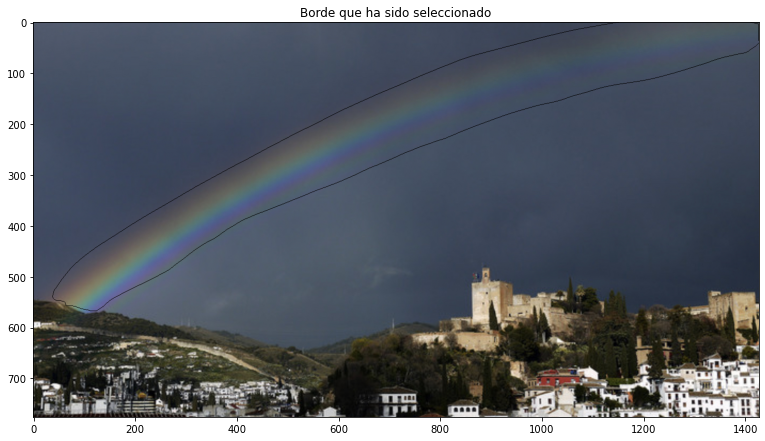

In [8]:
# Código 7: Ejemplo de cálculo del borde y función para visualizarlo 

def ViewBoundary (inputImage: np.ndarray , boundary: set): 
    '''Muestra en negro los puntos que han sido seleccionados como borde
    inputChannel: Imagen sobre la que se dibuja el borde.
    boundary: conjunto de pares de coordenadas sobre los que se va a dibujar
    '''
    new_image = np.copy(inputImage)
    for x,y in boundary:
        new_image[x][y][0] = new_image[x][y][1] = new_image[x][y][2] = 0.0
    PrintOneImage(new_image, 'Borde que ha sido seleccionado')

# Calculamos borde y lo mostramos 
channel = 0 # Channel of the image  
inputChannel = imgArcoiris[:, :, channel]
boundary = SourceBoundary(inputChannel, setRegionesSeleccionadasArcoiris)
ViewBoundary(imgArcoiris, boundary)

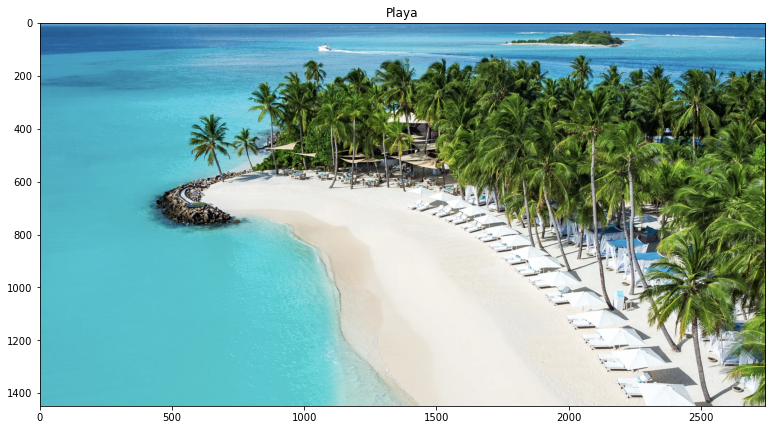

In [9]:
#Playa 
pathPlaya = path + 'Playa2.png'
imgPlaya = ReadImage(pathPlaya, flagColor) 
PrintOneImage(imgPlaya, 'Playa')



# Discrete Poisson Solver  

Centrémonos ahora en el objetivo principal que es calcula la función de interpolación $f_p$. Para ello por como hemos explicado en la memoria es necesario resolver el sistema: 

Para todo $p \in \Omega$
$$|N_p| f_p - \sum_{q \in N_p \cap \Omega} f_q = \sum _{q \in N_p \cap \partial \Omega} f_q ^* + \sum_{q \in N_p} v_{pq}.$$  


Probaremos primero un a utilizar un sistema linear ya implementado por numpy: 

https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

Como hay $n=|\Omega|$ incógnitas definiremos una matriz $n \times n$. 

In [11]:
# Definimos imágenes y parámetros con las que vamos a trabajar 
# TODO: es necesario trabajar con un canal y repetir el proceso por cada canal :)
# Como prueba lo haré con uno solo, no pensado mucho las consecuencias que eso supondría para el resto de funciones
# TODO comprobar que trabajar con un canal así es compatible con las funciones setRegionesSeleccionadas 
# Issue #7
source = imgArcoiris[:,:,0] # Imagen de la que se extrae la región que se quiere clonar
targetImg = imgPlaya[:,:,1]  # Imagen donde se va a posicionar la nueva región 
selectedSet = setRegionesSeleccionadasArcoiris # Conjunto de puntos con las región selecciónada, a de calcularse previamente
# Calculamos borde del arcoiris 
sourceBoundary = SourceBoundary(targetImg, selectedSet)  #TODO issue#14


# Calculamos el campo de escalares 
V = GuidanceFieldGenerator(source) # imagen original de la que se extrae la región seleccionada
                                   # Nótese que aquí se trabaja con las coordenadas de esos píxeles
# Ejemplo de resolución ecuación para el caso del arcoiris 
omega_len = len(selectedSet)
equation = np.zeros((omega_len, omega_len))
output = np.zeros(omega_len)
column = {}
max_index = 0      # lleva la cuenta del índice máximo de la columna de la matriz
current_index = 0  # índice de la columna actual para el pixel p

for equation_index,p in enumerate(selectedSet): 
    print( f'Cálculo de ecuación {equation_index}/{omega_len}')
    # ___ Matriz de coeficientes _____
    #Cálculo de la columna de la matriz 
    if p in column.keys(): 
        current_index = column[p]
    else:
        current_index = max_index
        max_index += 1
    # Cálculo de N_p, vecinos
    Np = Neighborhood(p, targetImg) # Creo que el tiempo de tardaza está  aquí # TODO comprobar
    Np_cardinality = len(Np)
    # entrada para |N_p| f_p 
    equation[equation_index][current_index] = Np_cardinality
    # entrada para  - \sum_{q \in N_p \cap \Omega} f_q 
    for q in Np:
        q = tuple(q)
        # Cálculo columna 
        if q in column.keys(): 
            current_index = column[q]
        else:
            current_index = max_index
            max_index += 1
        # entrada para  - \sum_{q \in N_p \cap \Omega} f_q 
        if q in selectedSet:
            equation[equation_index][current_index] = -1
        # \sum_{q \in N_p} v_{pq} término independiente 
        output[equation_index] += V(p,q)
        # Término independiente \sum _{q \in N_p \cap \partial \Omega} f_q ^* 
        if q in sourceBoundary:
            output[equation_index] += targetImg[q[0]][q[1]]
    
    # REsolvemos sistema
    # TODO: añadir a blibliografía https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

    f = np.linalg.solve(equation, output)


Cálculo de ecuación 0/164059


In [24]:
# Definimos imágenes y parámetros con las que vamos a trabajar 
# TODO: es necesario trabajar con un canal y repetir el proceso por cada canal :)
# Como prueba lo haré con uno solo, no pensado mucho las consecuencias que eso supondría para el resto de funciones
# TODO comprobar que trabajar con un canal así es compatible con las funciones setRegionesSeleccionadas 
# Issue #7
source = imgArcoiris[:,:,0] # Imagen de la que se extrae la región que se quiere clonar
targetImg = imgPlaya[:,:,1]  # Imagen donde se va a posicionar la nueva región 
selectedSet = setRegionesSeleccionadasArcoiris # Conjunto de puntos con las región selecciónada, a de calcularse previamente
# Calculamos borde del arcoiris 
sourceBoundary = SourceBoundary(targetImg, selectedSet)  #TODO issue#14

# Calculamos el campo de escalares 
V = GuidanceFieldGenerator(source) # imagen original de la que se extrae la región seleccionada
                                   # Nótese que aquí se trabaja con las coordenadas de esos píxeles
# Ejemplo de resolución ecuación para el caso del arcoiris 
omega_len = len(selectedSet)
equation = lil_matrix((omega_len, omega_len), dtype = np.int8)
output = np.zeros(omega_len)
column = {}

for index,p in enumerate(selectedSet):
    column[p] = index

for index,p in enumerate(selectedSet):
    print(f"Índice {index}")
    # Cálculo de N_p, vecinos
    Np = Neighborhood(p, targetImg) # Creo que el tiempo de tardaza está  aquí # TODO comprobar
    Np_cardinality = len(Np)
    # entrada para |N_p| f_p 
    equation[index, index] = Np_cardinality
    # entrada para  - \sum_{q \in N_p \cap \Omega} f_q 
    for q in Np:
        q = tuple(q)
        # entrada para  - \sum_{q \in N_p \cap \Omega} f_q 
        if q in selectedSet:
            equation[index, column[q]] = -1
        # \sum_{q \in N_p} v_{pq} término independiente
        print(f"Índice1: [{p[0]},{p[1]}]//Índice2: [{q[0]},{q[1]}]")
        output[index] += V(p,q)
        # Término independiente \sum _{q \in N_p \cap \partial \Omega} f_q ^* 
        if q in sourceBoundary:
            output[index] += targetImg[q[0]][q[1]]

print("Falta resolución")

# REsolvemos sistema
# TODO: añadir a blibliografía https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

f = scipy.sparse.linalg.spsolve(equation, output)


Índice 0
Índice 1
Índice 2
Índice 3
Índice 4
Índice 5
Índice 6
Índice 7
Índice 8
Índice 9
Índice 10
Índice 11
Índice 12
Índice 13
Índice 14
Índice 15
Índice 16
Índice 17
Índice 18
Índice 19
Índice 20
Índice 21
Índice 22
Índice 23
Índice 24
Índice 25
Índice 26
Índice 27
Índice 28
Índice 29
Índice 30
Índice 31
Índice 32
Índice 33
Índice 34
Índice 35
Índice 36
Índice 37
Índice 38
Índice 39
Índice 40
Índice 41
Índice 42
Índice 43
Índice 44
Índice 45
Índice 46
Índice 47
Índice 48
Índice 49
Índice 50
Índice 51
Índice 52
Índice 53
Índice 54
Índice 55
Índice 56
Índice 57
Índice 58
Índice 59
Índice 60
Índice 61
Índice 62
Índice 63
Índice 64
Índice 65
Índice 66
Índice 67
Índice 68
Índice 69
Índice 70
Índice 71
Índice 72
Índice 73
Índice 74
Índice 75
Índice 76
Índice 77
Índice 78
Índice 79
Índice 80
Índice 81
Índice 82
Índice 83
Índice 84
Índice 85
Índice 86
Índice 87
Índice 88
Índice 89
Índice 90
Índice 91
Índice 92
Índice 93
Índice 94
Índice 95
Índice 96
Índice 97
Índice 98
Índice 99
Índice 100

IndexError: index 1427 is out of bounds for axis 0 with size 1427

# Bibliografía y otros recursos  

[1] Web. Título: Implementación de funciones de la función `shape`. URL: https://github.com/pandas-dev/pandas/blob/master/pandas/core/frame.py Fecha última consulta: 01-01-22. Línea de código: 822-842.

[2] Web. Título: *Internal working of the Len() function in Python. URL: https://www.geeksforgeeks.org/internal-working-of-the-len-function-in-python/ autor: GeeksforGeeks. Fecha última consulta: 01-01-22. 

[3] Artículo *Poisson Image Editing* Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. DOI:https://doi.org/10.1145/882262.882269